In [1]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.5/61.5 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 3.7 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip


In [68]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import regression as reg
from scipy import stats
from matplotlib import pyplot as plt
import pickle
import netpixi
from netpixi.integration.gt import *
from regression.integration.gt import *
from graph_tool import centrality

In [3]:
df = pd.read_csv('etf_funds/ETFs.csv')

In [4]:
fund_names = df["fund_symbol"].values

In [5]:
# funds_historical_data = yf.download(list(fund_names), period='1y')
# funds_historical_data["Adj Close"].to_csv("etf_funds/historical_data.csv")

In [6]:
file_df = pd.read_csv("etf_funds/historical_data.csv")

In [7]:
fund_names = list(file_df.columns[1:].values)
fund_returns = []
fund_vol  = []
fund_sharpe = []


for fund in fund_names:
    fund_list = file_df[fund].values
    fund_return = (fund_list[-1] - fund_list[0]) / fund_list[0]
    fund_volatility = file_df[fund].pct_change().std() * np.sqrt(252)
    
    fund_returns.append(fund_return)
    fund_vol.append(fund_volatility)
    fund_sharpe.append(fund_return / fund_volatility)
 

In [8]:
df_final = pd.DataFrame(data={ 
    "Symbol": fund_names, 
    "1Y Return": fund_returns, 
    "1Y Volatility": fund_vol, 
    "1Y Sharpe": fund_sharpe 
})

In [9]:
# Removendo fundos que já encerraram as operações
df_final = df_final.dropna()

In [10]:
df_final

,Symbol,1Y Return,1Y Volatility,1Y Sharpe
0,AAA,-0.015278,0.022634,-0.675021
1,AAAU,-0.078962,0.141250,-0.559023
2,AADR,-0.251947,0.250346,-1.006395
3,AAXJ,-0.337440,0.232847,-1.449193
4,ABEQ,-0.009397,0.136445,-0.068873
...,...,...,...,...
2305,ZHDG,-0.162616,0.136425,-1.191983
2306,ZIG,-0.139991,0.225021,-0.622125
2307,ZIVZF,-0.234234,0.554628,-0.422327
2308,ZROZ,-0.433651,0.276078,-1.570754


In [11]:
# fund_holdings = {}
# unique_assets = []
# error_list = []

# for index, fund in enumerate(list(df_final["Symbol"].values)):
#     try:
#         asset = yf.Ticker(fund)
#         holdings_info = asset.get_info()['holdings']
#         holdings = {}
        
#         for holding in holdings_info:
#             holdings[holding["holdingName"]] = holding["holdingPercent"]
#             unique_assets.append(holding["holdingName"])
        
#         fund_holdings[fund] = holdings
#         if (index % 100 == 0):
#             print(index)
#     except:
#         error_list.append(fund)

In [12]:
# f = open('fund_holdings.pckl', 'wb')
# pickle.dump(fund_holdings, f)
# f.close()

# f = open('unique_assets.pckl', 'wb')
# pickle.dump(list(set(unique_assets)), f)
# f.close()

# f = open('error_list.pckl', 'wb')
# pickle.dump(error_list, f)
# f.close()

In [13]:
f = open('error_list.pckl', 'rb')
error_list = pickle.load(f)
f.close()

f = open('unique_assets.pckl', 'rb')
unique_assets = pickle.load(f)
f.close()

f = open('fund_holdings.pckl', 'rb')
fund_holdings = pickle.load(f)
f.close()

In [14]:
matrix = pd.DataFrame(columns=list(set(unique_assets)), index=fund_holdings.keys())
matrix.fillna(0, inplace=True)

invalid_funds = []

for fund in fund_holdings:
    for asset in fund_holdings[fund]:
        if fund_holdings[fund][asset] > 1:
            invalid_funds.append(fund)
        matrix.loc[fund, asset] = fund_holdings[fund][asset]

In [22]:
matrix = matrix.drop(list(set(invalid_funds)))

In [23]:
# Euclidean distance between two vectors for all funds
from scipy.spatial.distance import pdist, squareform
distances = pd.DataFrame(squareform(pdist(matrix, 'euclidean')), columns=matrix.index, index=matrix.index)

distances

,AAA,AAAU,AADR,AAXJ,ABEQ,ACES,ACIO,ACSI,ACTV,ACVF,...,YLDE,YMAR,YOLO,YPS,YXI,YYY,ZHDG,ZIG,ZROZ,ZSL
AAA,0.000000,1.012001,0.205556,0.195133,0.230977,0.223306,0.203392,0.229159,0.181673,0.177798,...,0.189402,0.971054,0.390675,0.157000,0.479807,0.208836,0.155390,0.219455,0.163359,0.972715
AAAU,1.012001,0.000000,1.009013,1.006941,1.014497,1.012778,1.008574,1.014085,1.004420,1.003726,...,1.005846,1.385208,1.062300,1.000251,1.098211,1.009686,1.000000,1.011936,1.001269,1.386372
AADR,0.205556,1.009013,0.000000,0.178992,0.217512,0.209348,0.187961,0.215580,0.164214,0.159917,...,0.172726,0.967940,0.382868,0.136419,0.473472,0.193839,0.134563,0.205236,0.143692,0.969606
AAXJ,0.195133,1.006941,0.178992,0.000000,0.207690,0.199124,0.176502,0.205666,0.150963,0.146277,...,0.160180,0.965780,0.377375,0.120141,0.469041,0.182749,0.118029,0.194796,0.128340,0.967450
ABEQ,0.230977,1.014497,0.217512,0.207690,0.000000,0.234358,0.215468,0.239942,0.195098,0.181068,...,0.202315,0.973655,0.397096,0.172358,0.485049,0.220615,0.170893,0.230692,0.178170,0.975311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
YYY,0.208836,1.009686,0.193839,0.182749,0.220615,0.212569,0.191543,0.218710,0.168301,0.164111,...,0.176616,0.968642,0.384639,0.141312,0.474905,0.000000,0.139522,0.208521,0.148346,0.970306
ZHDG,0.155390,1.000000,0.134563,0.118029,0.170893,0.160372,0.131233,0.168427,0.094122,0.086406,...,0.108290,0.958541,0.358442,0.022424,0.453948,0.139522,0.000000,0.154966,0.050400,0.960223
ZIG,0.219455,1.011936,0.205236,0.194796,0.230692,0.223011,0.203068,0.228871,0.181310,0.177427,...,0.189054,0.970987,0.390507,0.156580,0.479670,0.208521,0.154966,0.000000,0.162956,0.972647
ZROZ,0.163359,1.001269,0.143692,0.128340,0.178170,0.168105,0.140579,0.175806,0.106767,0.100031,...,0.119444,0.959865,0.361968,0.055163,0.456737,0.148346,0.050400,0.162956,0.000000,0.961545


In [24]:
distances.std().mean()

0.19921049611281885

In [102]:
media_jrg = distances.mean().mean()
media_jrg

0.2948676563239358

In [103]:
g = Graph(directed=False) # não-dirigido

In [104]:
for fund in fund_holdings.keys():
    try:
        g.add_vertex(fund)
    except:
        print(fund)

In [105]:
for row, col in distances.iterrows():
    for index, value in col.items():
        if row == index: 
            continue
            
        if value > media_jrg:
            continue
        
        try:
            g.add_edge(row, index)
        except:
            pass

In [106]:
n = g.num_vertices()
n

2189

In [107]:
m = g.num_edges()
m

1564676

In [108]:
g = gt_clean(g)

In [109]:
bc, _ = centrality.betweenness(g)
g.add_vp('betweenness', bc)
gt_data(g).loc[:, :].sort_values('betweenness', ascending=False)

,betweenness
id,
DRN,0.012122
EDZ,0.006486
TYO,0.005408
UUP,0.003605
SH,0.002167
...,...
RPAR,0.000000
LTPZ,0.000000
FNGD,0.000000


In [110]:
import cpnet

from graph_tool import spectral

In [111]:
matrix = spectral.adjacency(g)

algorithm = cpnet.Rombach()
algorithm.detect(matrix)
c = algorithm.get_coreness()

g.add_vp('coreness')
for i, coreness in c.items():
    v = g.get_vertex_by_index(i)
    v['coreness'] = float(coreness)

KeyboardInterrupt: 

In [112]:
from graph_tool import clustering

lc = clustering.local_clustering(g)
g.add_vp('clustering', lc)

In [113]:
ntw_metrics = gt_data(g)

In [114]:
metrics = pd.merge(df_final[['Symbol','1Y Return', '1Y Volatility', '1Y Sharpe']], ntw_metrics, left_on='Symbol', right_on='id', how='inner')

In [115]:
metrics["Antifragile"] = 1 / metrics["1Y Volatility"]

In [116]:
metrics

,Symbol,1Y Return,1Y Volatility,1Y Sharpe,betweenness,clustering,Antifragile
0,AAA,-0.015278,0.022634,-0.675021,0.000004,0.993556,44.181771
1,AADR,-0.251947,0.250346,-1.006395,0.000006,0.990614,3.994467
2,AAXJ,-0.337440,0.232847,-1.449193,0.000010,0.986186,4.294664
3,ABEQ,-0.009397,0.136445,-0.068873,0.000003,0.995700,7.328985
4,ACES,-0.314696,0.451770,-0.696585,0.000004,0.993897,2.213515
...,...,...,...,...,...,...,...
1841,YPS,-0.135272,0.230933,-0.585763,0.000030,0.975582,4.330265
1842,YYY,-0.255577,0.147023,-1.738349,0.000005,0.991362,6.801654
1843,ZHDG,-0.162616,0.136425,-1.191983,0.000036,0.974589,7.330057
1844,ZIG,-0.139991,0.225021,-0.622125,0.000004,0.993556,4.444021


In [133]:
result = stats.linregress(x=metrics['betweenness'], y=metrics['1Y Sharpe'])

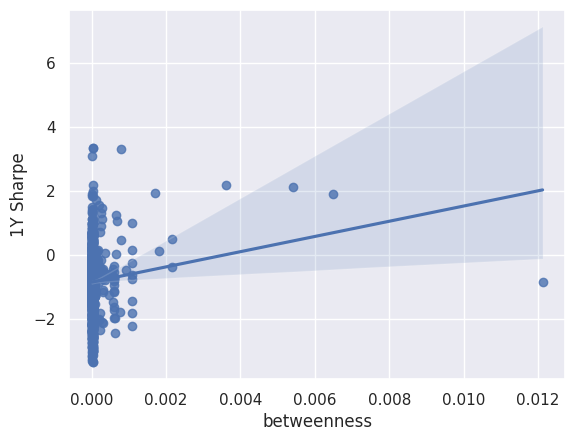

In [134]:
sns.regplot(x=metrics['betweenness'], y=metrics['1Y Sharpe']);

In [135]:
result.pvalue

1.7766221617458926e-06

In [136]:
result

LinregressResult(slope=237.41539411171004, intercept=-0.8516322414641755, rvalue=0.11092217118922, pvalue=1.7766221617458926e-06, stderr=49.53609441258811, intercept_stderr=0.018995139594729395)